In [1]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
file_path = './Users/emrekaya/Downloads/UrbanSound8K'
file_viz = glob.glob('/Users/emrekaya/Downloads/UrbanSound8K/audio/fold1/*')
urbansound8k = pd.read_csv("/Users/emrekaya/Downloads/UrbanSound8K/metadata/UrbanSound8K.csv")

In [3]:
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
class_map = {'0' : 'air_conditioner',
             '1' : 'car_horn',
             '2' : 'children_playing', 
             '3' : 'dog_bark', 
             '4' : 'drilling', 
             '5' : 'engine_idling', 
             '6' : 'gun_shot',
             '7' : 'jackhammer',
             '8' : 'siren',
             '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [5]:
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [6]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

/var/folders/4k/_1lkfzv95m52sx0cjw_m6rkc0000gn/T/ipykernel_85901/2846493538.py:3: FutureWarning: Pass orig_sr=44100, target_sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data_22k = librosa.resample(data.T, fsr, sr)
/var/folders/4k/_1lkfzv95m52sx0cjw_m6rkc0000gn/T/ipykernel_85901/2846493538.py:3: FutureWarning: Pass orig_sr=96000, target_sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data_22k = librosa.resample(data.T, fsr, sr)
/var/folders/4k/_1lkfzv95m52sx0cjw_m6rkc0000gn/T/ipykernel_85901/2846493538.py:3: FutureWarning: Pass orig_sr=48000, target_sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data_22k = librosa.resample(data.T, fsr, sr)
/var/folders/4k/_1lkfzv95m52sx0cjw_m6rkc0000gn/T/ipykernel_85901/2846493538.py:3: FutureWarning: Pass orig_sr=44100, target_sr=22050 as keyword args. From version 0.10 p

[('air_conditioner', (88200,)),
 ('car_horn', (10264,)),
 ('children_playing', (88200,)),
 ('dog_bark', (88200,)),
 ('drilling', (88200,)),
 ('engine_idling', (88200,)),
 ('gun_shot', (25104,)),
 ('jackhammer', (63284,)),
 ('siren', (88200,)),
 ('street_music', (88200,))]

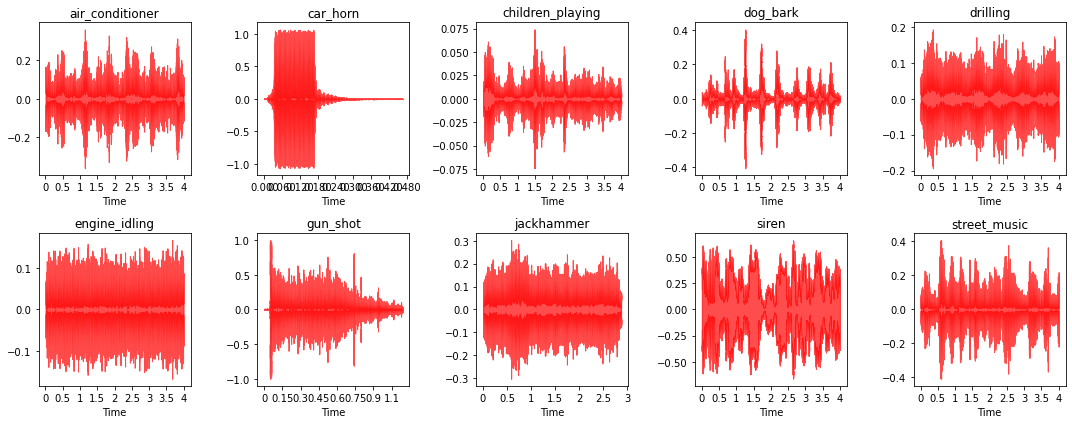

In [7]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveshow(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

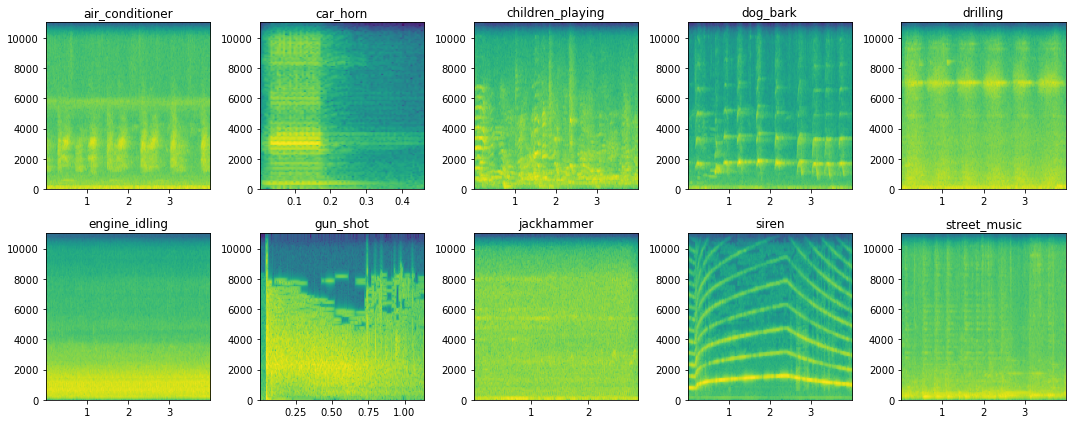

In [8]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

In [9]:
class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [10]:
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in urbansound8k.iterrows():
    
    file_name = "/Users/emrekaya/Downloads/UrbanSound8K/audio/fold"+str(row["fold"])+'/'+str(row["slice_file_name"])
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [11]:
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs


In [12]:
features = []

# Iterate through each sound file and extract the features 
for index, row in urbansound8k.iterrows():
    
    file_name = "/Users/emrekaya/Downloads/UrbanSound8K/audio/fold"+str(row["fold"])+'/'+str(row["slice_file_name"])
    
    class_label = row["classID"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

/Users/emrekaya/tensorflow-test/env/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
/Users/emrekaya/tensorflow-test/env/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
/Users/emrekaya/tensorflow-test/env/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


In [13]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)

In [14]:
x_train1 = x_train 
x_test1 = x_test
y_train1 = y_train
y_test1 = y_test
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

6985
1747
6985
1747


In [15]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
print(x_train.shape)

num_labels = yy.shape[1]
filter_size = 3

(6985, 40, 174, 1)


In [16]:
# Constructing model with RELu and SoftMax activation functions:
model_relu = Sequential()
model_relu.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))
model_relu.add(GlobalAveragePooling2D())
model_relu.add(Flatten())
model_relu.add(Dense(num_labels, activation='softmax'))

Metal device set to: Apple M1 Max


2022-10-13 14:42:44.525670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-13 14:42:44.526295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model_relu.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [18]:
model_relu.summary()

# Calculate pre-training accuracy 
score = model_relu.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

2022-10-13 14:42:44.821973: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-13 14:42:44.957047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 1s 6ms/step - loss: 5.9140 - accuracy: 0.1025
Pre-training accuracy: 10.2461%


In [19]:
num_epochs = 300
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history_relu = model_relu.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300


2022-10-13 14:42:45.673639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 3.5764 - accuracy: 0.2163
Epoch 1: val_loss improved from inf to 2.01676, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 38ms/step - loss: 3.5764 - accuracy: 0.2163 - val_loss: 2.0168 - val_accuracy: 0.3320
Epoch 2/300
27/28 [===========================>..] - ETA: 0s - loss: 1.8068 - accuracy: 0.3617
Epoch 2: val_loss improved from 2.01676 to 1.81393, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 31ms/step - loss: 1.8043 - accuracy: 0.3619 - val_loss: 1.8139 - val_accuracy: 0.3675
Epoch 3/300
27/28 [===========================>..] - ETA: 0s - loss: 1.5262 - accuracy: 0.4499
Epoch 3: val_loss improved from 1.81393 to 1.66680, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 30ms/step - loss: 1.5272 - accuracy: 0.4490 - val_loss: 1.6668 - val_accuracy: 0.4001
Epoch 4/300
27

28/28 [==============================] - 1s 30ms/step - loss: 0.5726 - accuracy: 0.8034 - val_loss: 0.6664 - val_accuracy: 0.7785
Epoch 27/300
27/28 [===========================>..] - ETA: 0s - loss: 0.5721 - accuracy: 0.8048
Epoch 27: val_loss improved from 0.66638 to 0.64992, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 30ms/step - loss: 0.5725 - accuracy: 0.8049 - val_loss: 0.6499 - val_accuracy: 0.7916
Epoch 28/300
27/28 [===========================>..] - ETA: 0s - loss: 0.5557 - accuracy: 0.8087
Epoch 28: val_loss did not improve from 0.64992
28/28 [==============================] - 1s 30ms/step - loss: 0.5547 - accuracy: 0.8096 - val_loss: 0.6786 - val_accuracy: 0.7750
Epoch 29/300
27/28 [===========================>..] - ETA: 0s - loss: 0.5396 - accuracy: 0.8148
Epoch 29: val_loss improved from 0.64992 to 0.63787, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 30ms/step 

Epoch 54/300
27/28 [===========================>..] - ETA: 0s - loss: 0.3246 - accuracy: 0.8872
Epoch 54: val_loss improved from 0.46193 to 0.45035, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 30ms/step - loss: 0.3246 - accuracy: 0.8866 - val_loss: 0.4503 - val_accuracy: 0.8638
Epoch 55/300
27/28 [===========================>..] - ETA: 0s - loss: 0.3212 - accuracy: 0.8887
Epoch 55: val_loss improved from 0.45035 to 0.42393, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 31ms/step - loss: 0.3199 - accuracy: 0.8889 - val_loss: 0.4239 - val_accuracy: 0.8672
Epoch 56/300
27/28 [===========================>..] - ETA: 0s - loss: 0.3148 - accuracy: 0.8945
Epoch 56: val_loss did not improve from 0.42393
28/28 [==============================] - 1s 30ms/step - loss: 0.3163 - accuracy: 0.8936 - val_loss: 0.4524 - val_accuracy: 0.8512
Epoch 57/300
27/28 [===========================>..] - 

Epoch 83/300
27/28 [===========================>..] - ETA: 0s - loss: 0.2173 - accuracy: 0.9245
Epoch 83: val_loss did not improve from 0.35466
28/28 [==============================] - 1s 30ms/step - loss: 0.2175 - accuracy: 0.9246 - val_loss: 0.3614 - val_accuracy: 0.8907
Epoch 84/300
27/28 [===========================>..] - ETA: 0s - loss: 0.2147 - accuracy: 0.9242
Epoch 84: val_loss did not improve from 0.35466
28/28 [==============================] - 1s 29ms/step - loss: 0.2141 - accuracy: 0.9244 - val_loss: 0.3794 - val_accuracy: 0.8821
Epoch 85/300
27/28 [===========================>..] - ETA: 0s - loss: 0.2144 - accuracy: 0.9255
Epoch 85: val_loss improved from 0.35466 to 0.33289, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 30ms/step - loss: 0.2145 - accuracy: 0.9256 - val_loss: 0.3329 - val_accuracy: 0.8975
Epoch 86/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1981 - accuracy: 0.9330
Epoch 86: val_loss d

27/28 [===========================>..] - ETA: 0s - loss: 0.1593 - accuracy: 0.9421
Epoch 112: val_loss did not improve from 0.28433
28/28 [==============================] - 1s 29ms/step - loss: 0.1596 - accuracy: 0.9422 - val_loss: 0.2979 - val_accuracy: 0.9056
Epoch 113/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1572 - accuracy: 0.9450
Epoch 113: val_loss did not improve from 0.28433
28/28 [==============================] - 1s 29ms/step - loss: 0.1572 - accuracy: 0.9450 - val_loss: 0.3054 - val_accuracy: 0.9090
Epoch 114/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1371 - accuracy: 0.9517
Epoch 114: val_loss did not improve from 0.28433
28/28 [==============================] - 1s 29ms/step - loss: 0.1374 - accuracy: 0.9518 - val_loss: 0.2931 - val_accuracy: 0.9147
Epoch 115/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1451 - accuracy: 0.9478
Epoch 115: val_loss did not improve from 0.28433
28/28 [==============================] -

27/28 [===========================>..] - ETA: 0s - loss: 0.1152 - accuracy: 0.9576
Epoch 141: val_loss did not improve from 0.27470
28/28 [==============================] - 1s 30ms/step - loss: 0.1158 - accuracy: 0.9573 - val_loss: 0.2916 - val_accuracy: 0.9290
Epoch 142/300
26/28 [==========================>...] - ETA: 0s - loss: 0.1304 - accuracy: 0.9542
Epoch 142: val_loss did not improve from 0.27470
28/28 [==============================] - 1s 30ms/step - loss: 0.1284 - accuracy: 0.9548 - val_loss: 0.3107 - val_accuracy: 0.9141
Epoch 143/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1164 - accuracy: 0.9604
Epoch 143: val_loss did not improve from 0.27470
28/28 [==============================] - 1s 29ms/step - loss: 0.1158 - accuracy: 0.9606 - val_loss: 0.2828 - val_accuracy: 0.9199
Epoch 144/300
27/28 [===========================>..] - ETA: 0s - loss: 0.1074 - accuracy: 0.9605
Epoch 144: val_loss did not improve from 0.27470
28/28 [==============================] -

27/28 [===========================>..] - ETA: 0s - loss: 0.0841 - accuracy: 0.9708
Epoch 170: val_loss did not improve from 0.26191
28/28 [==============================] - 1s 29ms/step - loss: 0.0841 - accuracy: 0.9705 - val_loss: 0.3436 - val_accuracy: 0.9170
Epoch 171/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0957 - accuracy: 0.9657
Epoch 171: val_loss did not improve from 0.26191
28/28 [==============================] - 1s 29ms/step - loss: 0.0956 - accuracy: 0.9658 - val_loss: 0.3323 - val_accuracy: 0.9210
Epoch 172/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0904 - accuracy: 0.9644
Epoch 172: val_loss did not improve from 0.26191
28/28 [==============================] - 1s 29ms/step - loss: 0.0897 - accuracy: 0.9648 - val_loss: 0.2859 - val_accuracy: 0.9296
Epoch 173/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0853 - accuracy: 0.9708
Epoch 173: val_loss did not improve from 0.26191
28/28 [==============================] -

28/28 [==============================] - 1s 30ms/step - loss: 0.0752 - accuracy: 0.9737 - val_loss: 0.3033 - val_accuracy: 0.9239
Epoch 200/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0744 - accuracy: 0.9735
Epoch 200: val_loss did not improve from 0.26020
28/28 [==============================] - 1s 29ms/step - loss: 0.0741 - accuracy: 0.9735 - val_loss: 0.3013 - val_accuracy: 0.9342
Epoch 201/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0836 - accuracy: 0.9701
Epoch 201: val_loss did not improve from 0.26020
28/28 [==============================] - 1s 29ms/step - loss: 0.0837 - accuracy: 0.9701 - val_loss: 0.2775 - val_accuracy: 0.9290
Epoch 202/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0940 - accuracy: 0.9657
Epoch 202: val_loss improved from 0.26020 to 0.24532, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 30ms/step - loss: 0.0938 - accuracy: 0.9656 - val_loss: 0.2453 - v

Epoch 229/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0660 - accuracy: 0.9774
Epoch 229: val_loss did not improve from 0.24532
28/28 [==============================] - 1s 29ms/step - loss: 0.0659 - accuracy: 0.9775 - val_loss: 0.2826 - val_accuracy: 0.9279
Epoch 230/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0586 - accuracy: 0.9787
Epoch 230: val_loss did not improve from 0.24532
28/28 [==============================] - 1s 29ms/step - loss: 0.0589 - accuracy: 0.9788 - val_loss: 0.3080 - val_accuracy: 0.9256
Epoch 231/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0799 - accuracy: 0.9712
Epoch 231: val_loss improved from 0.24532 to 0.23618, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 1s 31ms/step - loss: 0.0806 - accuracy: 0.9708 - val_loss: 0.2362 - val_accuracy: 0.9388
Epoch 232/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0650 - accuracy: 0.9782
Epoch 232: va

27/28 [===========================>..] - ETA: 0s - loss: 0.0547 - accuracy: 0.9829
Epoch 258: val_loss did not improve from 0.22980
28/28 [==============================] - 1s 29ms/step - loss: 0.0550 - accuracy: 0.9827 - val_loss: 0.2550 - val_accuracy: 0.9388
Epoch 259/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0542 - accuracy: 0.9815
Epoch 259: val_loss did not improve from 0.22980
28/28 [==============================] - 1s 29ms/step - loss: 0.0542 - accuracy: 0.9815 - val_loss: 0.3096 - val_accuracy: 0.9267
Epoch 260/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0589 - accuracy: 0.9789
Epoch 260: val_loss did not improve from 0.22980
28/28 [==============================] - 1s 29ms/step - loss: 0.0590 - accuracy: 0.9788 - val_loss: 0.3099 - val_accuracy: 0.9359
Epoch 261/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0586 - accuracy: 0.9806
Epoch 261: val_loss did not improve from 0.22980
28/28 [==============================] -

Epoch 288/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0611 - accuracy: 0.9773
Epoch 288: val_loss did not improve from 0.22980
28/28 [==============================] - 1s 29ms/step - loss: 0.0609 - accuracy: 0.9774 - val_loss: 0.2425 - val_accuracy: 0.9353
Epoch 289/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0610 - accuracy: 0.9789
Epoch 289: val_loss did not improve from 0.22980
28/28 [==============================] - 1s 29ms/step - loss: 0.0616 - accuracy: 0.9790 - val_loss: 0.2687 - val_accuracy: 0.9416
Epoch 290/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0430 - accuracy: 0.9845
Epoch 290: val_loss did not improve from 0.22980
28/28 [==============================] - 1s 30ms/step - loss: 0.0430 - accuracy: 0.9845 - val_loss: 0.2641 - val_accuracy: 0.9370
Epoch 291/300
27/28 [===========================>..] - ETA: 0s - loss: 0.0465 - accuracy: 0.9845
Epoch 291: val_loss did not improve from 0.22980
28/28 [===================

In [ ]:
# Evaluating the model on the training and testing set

score = model_relu.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model_relu.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

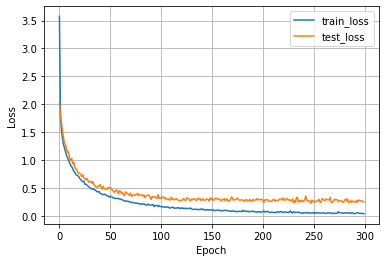

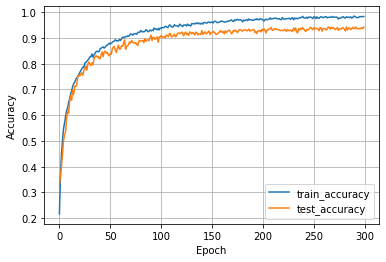

In [21]:
metrics = history_relu.history

plt.plot(history_relu.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


plt.plot(history_relu.history['accuracy'], label='train_accuracy')
plt.plot(history_relu.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [22]:
# Construct model with ELU and Sigmoid activation functions:
model_elu = Sequential()
model_elu.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='elu'))
model_elu.add(BatchNormalization())
model_elu.add(MaxPooling2D(pool_size=(2,2)))
model_elu.add(Dropout(0.2))


model_elu.add(Conv2D(filters=32, kernel_size=2, activation='elu'))
model_elu.add(BatchNormalization())
model_elu.add(MaxPooling2D(pool_size=(2,2)))
model_elu.add(Dropout(0.2))


model_elu.add(Conv2D(filters=64, kernel_size=2, activation='elu'))
model_elu.add(BatchNormalization())
model_elu.add(MaxPooling2D(pool_size=(2,2)))
model_elu.add(Dropout(0.2))


model_elu.add(Conv2D(filters=128, kernel_size=2, activation='elu'))
model_elu.add(MaxPooling2D(pool_size=(2,2)))
model_elu.add(Dropout(0.2))
model_elu.add(GlobalAveragePooling2D())
model_elu.add(Flatten())
model_elu.add(Dense(num_labels, activation='softmax'))

In [23]:
model_elu.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [24]:
model_elu.summary()

# Calculate pre-training accuracy 
score = model_elu.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 39, 173, 16)       80        
                                                                 
 batch_normalization (BatchN  (None, 39, 173, 16)      64        
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 19, 86, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 19, 86, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 batch_normalization_1 (Batc  (None, 18, 85, 32)      

2022-10-13 14:46:55.153869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 1s 18ms/step - loss: 7.7167 - accuracy: 0.0841
Pre-training accuracy: 8.4144%


In [ ]:
num_epochs = 300
num_batch_size = 512

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history_elu = model_elu.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300


2022-10-13 14:46:56.496458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 2.1776 - accuracy: 0.2892
Epoch 1: val_loss improved from inf to 2.86002, saving model to saved_models/weights.best.basic_cnn.hdf5
14/14 [==============================] - 5s 328ms/step - loss: 2.1776 - accuracy: 0.2892 - val_loss: 2.8600 - val_accuracy: 0.1517
Epoch 2/300
14/14 [==============================] - ETA: 0s - loss: 1.5103 - accuracy: 0.4647
Epoch 2: val_loss improved from 2.86002 to 2.47695, saving model to saved_models/weights.best.basic_cnn.hdf5
14/14 [==============================] - 4s 289ms/step - loss: 1.5103 - accuracy: 0.4647 - val_loss: 2.4769 - val_accuracy: 0.2335
Epoch 3/300
14/14 [==============================] - ETA: 0s - loss: 1.3351 - accuracy: 0.5234
Epoch 3: val_loss improved from 2.47695 to 2.02865, saving model to saved_models/weights.best.basic_cnn.hdf5
14/14 [==============================] - 4s 286ms/step - loss: 1.3351 - accuracy: 0.5234 - val_loss: 2.0287 - val_accuracy: 0.3160
Epoch 4/300

In [ ]:
# Evaluating the model on the training and testing set
score = model_elu.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model_elu.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

In [ ]:

plt.plot(history_elu.history['accuracy'], label='train_accuracy')
plt.plot(history_elu.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [ ]:
metrics = history_elu.history
plt.plot(history_elu.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()